In [ ]:
# DRAFT experiments for modifying orbital parameters

In [1]:
using SpeedyWeather
using Dates
using GeoMakie
using CairoMakie

In [2]:
# 1. Define the grid and components
spectral_grid = SpectralGrid(trunc=31, nlayers=8)
output = NetCDFOutput(spectral_grid, PrimitiveWetModel, id="orbital_exp", output_dt=Minute(180))
add!(output, SpeedyWeather.TemperatureOutput(), SpeedyWeather.LargeScalePrecipitationOutput())  # output also temperature and precip

NetCDFOutput{Field{Float32, 1, Vector{Float32}, FullGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}}}
├ status: inactive/uninitialized
├ write restart file: true (if active)
├ interpolator: AnvilInterpolator{Float32, SpeedyWeather.RingGrids.GridGeometry{OctahedralGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}, Vector{Float32}, Vector{Int64}}, SpeedyWeather.RingGrids.AnvilLocator{Float32, Vector{Float32}, Vector{Int64}}}
├ path: output.nc (overwrite=false)
├ frequency: 10800 seconds
└┐ variables:
 ├ v: meridional wind [m/s]
 ├ humid: specific humidity [kg/kg]
 ├ temp: temperature [degC]
 ├ u: zonal wind [m/s]
 ├ pres: surface pressure [hPa]
 ├ precip_cond: accumulated large-scale precipitation [mm]
 └ vor: relative vorticity [s^-1]

In [3]:
# 2. Create land and ocean models
temperature = LandBucketTemperature(spectral_grid)
soil_moisture = LandBucketMoisture(spectral_grid)
land = LandModel(spectral_grid; temperature, soil_moisture)
ocean = SlabOcean(spectral_grid)

SlabOcean{Float32} <: AbstractOcean
├ temp_equator::Float32 = 302.0
├ temp_poles::Float32 = 273.0
├ specific_heat_capacity::Float32 = 4184.0
├ mixed_layer_depth::Float32 = 10.0
├ density::Float32 = 1000.0
├ mask::Bool = false
└ heat_capacity_mixed_layer::Float32 = 4.184e7

In [4]:
# 3. Make parameterisation choices
large_scale_condensation = ImplicitCondensation(spectral_grid)
convection = SimplifiedBettsMiller(spectral_grid)

SimplifiedBettsMiller{Float32, NoSurfacePerturbation} <: SpeedyWeather.AbstractConvection
├ nlayers::Int64 = 8
├ time_scale::Second = 14400 seconds
├ relative_humidity::Float32 = 0.7
└ surface_temp_humid::NoSurfacePerturbation = NoSurfacePerturbation <: SpeedyWeather.AbstractSurfacePerturbation


In [5]:
# 4. Modify orbital parameter (e.g., halve axial tilt or halve rotation and double length of day)
earth = Earth(spectral_grid,axial_tilt=11.7f0) # unit is degrees
#earth = Earth(spectral_grid,rotation=3.645f-5,length_of_day=127800.0f0) # units are rad/s and s, respectively

Earth{Float32} <: SpeedyWeather.AbstractPlanet
├ rotation::Float32 = 7.29e-5
├ gravity::Float32 = 9.81
├ daily_cycle::Bool = true
├ length_of_day::Second = 86400 seconds
├ seasonal_cycle::Bool = true
├ length_of_year::Second = 31557600 seconds
├ equinox::DateTime = 2000-03-20T00:00:00
├ axial_tilt::Float32 = 11.7
└ solar_constant::Float32 = 1365.0

In [6]:
# 5. Create models and initialise simulations
model_ctl = PrimitiveWetModel(spectral_grid; land, ocean, large_scale_condensation, convection)
model_exp = PrimitiveWetModel(spectral_grid; land, ocean, large_scale_condensation, convection, planet=earth)
simulation_ctl = initialize!(model_ctl)
simulation_exp = initialize!(model_exp)

Simulation{PrimitiveWetModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::PrimitiveWetModel{...}

In [7]:
# 6. Run the simulation
run!(simulation_ctl, period=Day(5))
run!(simulation_exp, period=Day(5))

Weather is speedy: 100%|██████████████████| Time: 0:00:01 (716.11 years/day)
Weather is speedy: 100%|██████████████████| Time: 0:00:01 (1025.81 years/day)


Simulation{PrimitiveWetModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::PrimitiveWetModel{...}

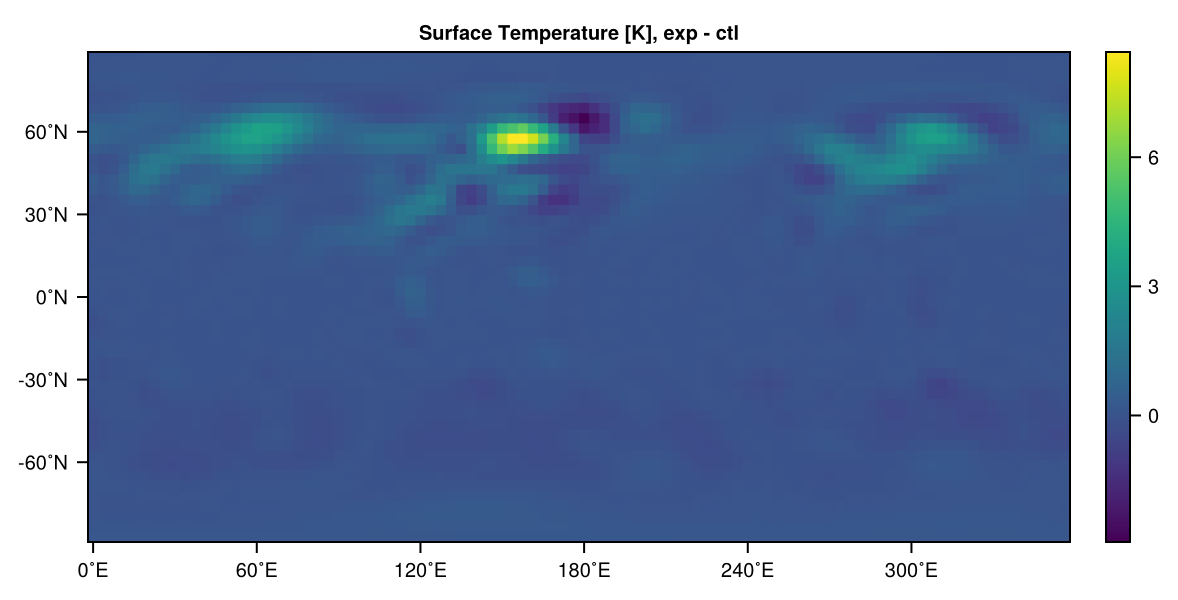

In [8]:
# 7. Simple difference plots
T = simulation_exp.diagnostic_variables.grid.temp_grid[:, 8] - simulation_ctl.diagnostic_variables.grid.temp_grid[:, 8]
heatmap(T, title="Surface Temperature [K], exp - ctl")

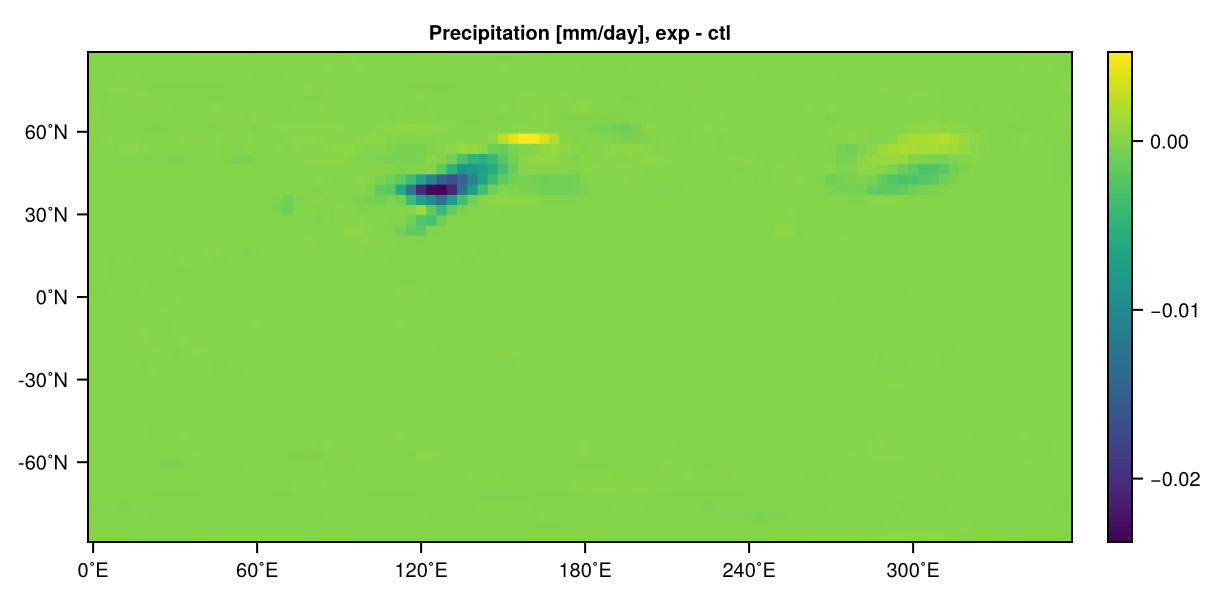

In [11]:
P = simulation_exp.diagnostic_variables.physics.precip_large_scale - simulation_ctl.diagnostic_variables.physics.precip_large_scale
heatmap(P, title="Precipitation [mm/day], exp - ctl")

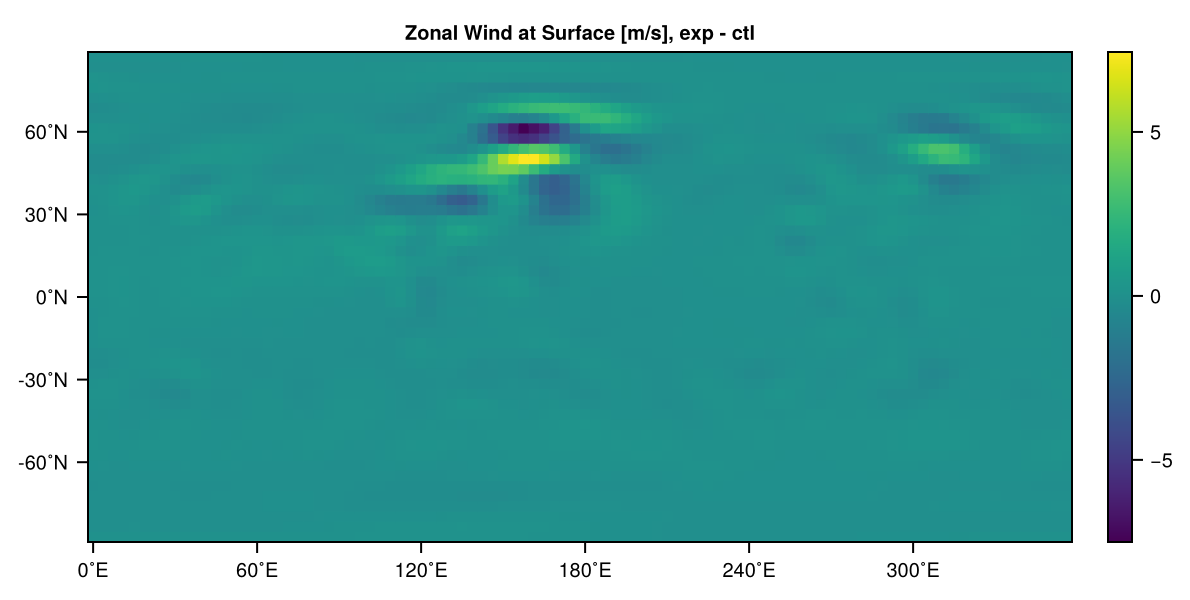

In [12]:
U = simulation_exp.diagnostic_variables.grid.u_grid[:, 8] - simulation_ctl.diagnostic_variables.grid.u_grid[:, 8]
heatmap(U, title="Zonal Wind at Surface [m/s], exp - ctl")